### CEG 4900 Trustworthy Machine Learning - Lab Assignment 2

# <center>Poisoning Attacks and Backdoor Attacks</center>

### 1. Overview
The learning objective of this lab assignment is for students to understand poisoning and backdoor attacks and the corresponding defenses against these attacks, including how to perform label flipping poisoning attack and hidden trigger backdoor attack, and how to defend against these attacks using data sanitization.

#### Lecture notes. 
Detailed coverage of these topics can be found in the following:
<li>Poisoning Attacks</li>
<li>Poisoning Defenses</li>
<li>Backdoor Attacks</li>

#### Code demonstrations.
<li>Code-Label Flipping Attack.ipynb</li>
<li>Code-Data Sanitization.ipynb</li>
<li>Code-Hidden Trigger Backdoor Attack.ipynb</li>

### 2. Submission
You need to submit a detailed lab report with code, running results, and answers to the questions. If you submit <font color='red'>a jupyter notebook (“Firstname-Lastname-4900-Lab2.ipynb”)</font>, please fill in this file directly and place the code, running results, and answers in order for each question. If you submit <font color='red'>a PDF report (“Firstname-Lastname-4900-Lab2.pdf”) with code file (“Firstname-Lastname-4900-Lab2.py”)</font>, please include the screenshots (code and running results) with answers for each question in the report.  

### 3. Questions (50 points)

#### Preparations: import the required libraries and define functions

Please run the following cell to import all the required libraries and define some necessary functions before complete the coding questions.

In [1]:
#Put all the libraries here
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, TensorDataset, ConcatDataset, Dataset

from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

import matplotlib as mpl
import matplotlib.pyplot as plt

#Set the random seed
np.random.seed(42)
torch.manual_seed(42)

#Define the training function for training model using train_dataloader
def train(epoch, model, train_dataloader, optimizer, lossfunction):
    model.train()
    
    train_loss = 0.0
    train_total, train_correct = 0.0, 0.0 
    
    for X_batch, y_batch in train_dataloader:
        optimizer.zero_grad()

        #Get the predicted output
        predictions = model(X_batch)

        #Calculate the loss
        loss = lossfunction(predictions, y_batch)
        
        #Update the weights usning gradient descent with Adam optimizer
        loss.backward()
        optimizer.step()
        
        #Convert probabilities to multi-class predictions (reutrn the class with the maximal proability)
        _, train_predicted = torch.max(predictions.data, 1)
        
        #Calculate the training statistics
        train_loss += loss.item()
        train_total += y_batch.size(0)
        train_correct += (train_predicted == y_batch).sum().item()

    print("epoch (%d): Train accuracy: %.4f, loss: %.3f" % (epoch, train_correct/train_total, train_loss/train_total))

#Define the test function for evaluating the trained model using test_dataloader
def test(model, test_dataloader):
    model.eval()
    
    test_correct, test_total = 0.0, 0.0
    y_test, y_pred = [], []
    
    with torch.no_grad():
        for X_batch, y_batch in test_dataloader:
            predictions = model(X_batch)
            
            _, test_predicted = torch.max(predictions.data, 1)
            test_total += y_batch.size(0)
            test_correct += (test_predicted == y_batch).sum().item()
            
            y_test += y_batch.tolist()
            y_pred += test_predicted.tolist()

    macro_f1 = f1_score(y_test, y_pred, average='macro')
    print('Test accuracy: %.4f, macro f1_score: %.4f' % (test_correct / test_total, macro_f1))

#Define the function that returns a predicted label for a single input sample
def predict_label(model, single_input):
    model.eval()  
    with torch.no_grad():
        prediction = model(single_input)
        _, predicted_label = torch.max(prediction.data, 1)
    
    return predicted_label

#Define the function that convert the raw dataset to PyTorch tensor
class WrappedDataset(Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset

    def __getitem__(self, index):
        x, y = self.base_dataset[index]
        return x, torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.base_dataset)

#Define the function that returns model parameters
def weight_parameters(model):
    model.eval()
    with torch.no_grad():
        parameters = list(model.parameters())[0]
    
    return parameters.detach().squeeze()

#Define the function that plots the given images
def plot_digits(instances, labels, images_per_row=5):
    for i in range(len(instances)):
        idx = i // images_per_row
        idy = i % images_per_row 
        ax[idx, idy].imshow(instances[i].squeeze())
        ax[idx, idy].set_title(class_names[labels[i]])
        ax[idx, idy].axis("off")

#Define the function to train a linear model and get y_hat for label flipping attack
def train_linear_model(epoch, linear_model, linear_model_optimizer, X, y, lossfunction):
    linear_model.train()
    linear_model_optimizer.zero_grad()
    linear_model_outputs = linear_model(X)
    linear_model_loss = -lossfunction(linear_model_outputs, y) #Need to place "-" before loss function
    linear_model_loss.backward()
    linear_model_optimizer.step()

    print('Epoch: {:d}'.format(epoch),
          'linear_model_loss: {:.4f}'.format(linear_model_loss.item()))

#Define the function to train a feature collision model for hidden trigger backdoor attack
def train_feature_collision_model(i, epoch, feature_collision_model, feature_collision_model_optimizer, triggered_instance, base_instance):
    feature_collision_model.train()
    feature_collision_model_optimizer.zero_grad()
    feature_collision_objective = feature_collision_model(triggered_instance, base_instance)
    feature_collision_objective.backward()
    feature_collision_model_optimizer.step()

## <font color='blue'>Label Flipping Attack</font>

#### Load and preprocess the `Android dataset` data

In Question 1, Question 2, Question 3, and Question 4, you will be using the `Breast Cancer Wisconsin dataset` to train a logistic regression model (binary classification model) to predict whether a tumor is `0: malignant` or `1: benign`, and perform a label flipping poisoning attack against this trained binary classification model. First, please run the following cell to load and preprocess the dataset.

In [2]:
#Load breast cancer wisconsin dataset
cancer = load_breast_cancer()

#Assign features and labels to X and y
X, y = cancer.data, cancer.target

#Class names
print("Class names: ", cancer.target_names)
#Feature number
print("Number of Features: ", X.shape[1])

#Split the data into two sets: 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

Class names:  ['malignant' 'benign']
Number of Features:  30
(455, 30)
(455,)
(114, 30)
(114,)


#### Question 1 (5 points):  

**Implement function `answer_one( )` to train a binary model `binary_model` using `(X_train, y_train)` from `Breast Cancer Wisconsin dataset`, and evaluate the model performance by calculating accuracy and F1 score.** 

**To simplify the model training process, please directly use `LogisticRegression` from Scikit-learn library.**

In [5]:
def answer_one():
    #Code here: build a logistic regression model using scikit-learn library LogisticRegression 
    binary_model = LogisticRegression(solver="newton-cg", random_state=42)
    #Code here: train binary_model using fit() function and (X_train, y_train) data 
    binary_model.fit(X_train, y_train)
    #Code here: use the trained model to predict on X_test
    y_pred = binary_model.predict(X_test)
    
    #Code here: use y_test and y_pred to calculate accuracy and F1 using sklearn functions
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    return binary_model, accuracy, f1

#Run your function in the cell to return the results
binary_model, clean_accuracy, clean_f1 = answer_one()
print(clean_accuracy, clean_f1)

0.956140350877193 0.9655172413793104


#### <font color='red'>Answer 1 (double click here to answer the questions in this cell):</font>  
Before label flipping attack<br>
The test accuracy is: ( 0.956 ) <br>
The test f1 score is: ( 0.966 )

#### Question 2 (10 points):  
**Implement a label flipping attack to poison the labels of the training data `y_train`, such that the logistic regression model re-trained on the poisoned data would make misclassification and thus decrease its test accuracy.** 

**First, define `LinearClassificationNet` to construct a linear classifier as sarrogate model to facilitate $\hat{y}$ optimization. After that, complete the function `answer_two( )` to use closed form solution to optimize lab flipping attack and obtain the flipping operation probabilities. The closed form of weight matrix is $W=(X^T\cdot X)^{-1}X^T\hat{y}$. Based on the weight matrix, the linear classifier can be fixed as $f_W(X) = X \cdot W = X \cdot (X^T\cdot X)^{-1}X^T\hat{y}$, where $\hat{y}$ is the only parameter in the function. $\hat{y}$ represents flipping operation probabilities to specify how possible a specified label should be flipped to 1.** 

In [6]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

train_num = X_train.shape[0]

epochs = 50
learning_rate = 0.01
weight_decay = 5e-4
lossfunction = nn.BCEWithLogitsLoss()

#Define the linear classifier clsss using closed form
class LinearClassificationNet(nn.Module):
    def __init__(self, train_num):
        super(LinearClassificationNet, self).__init__()
        #Code here: define self.y_hat as label flipping probability tensor with size of (train_num, 1)
        self.y_hat = torch.ones(train_num, 1, dtype=torch.float32)
        #Code here: initialize self.y_hat as 0.5 (multiply 0.5 with the tensor)
        self.y_hat = 0.5 * self.y_hat
        #Code here: add self.y_hat to the model parameter (requires_grad needs to be True)
        self.y_hat = Parameter(self.y_hat, requires_grad=True)

    def closedform(self, x):
        x_t = torch.transpose(x, 0, 1)
        x_x = torch.mm(x_t, x)               #X^T.X
        x_x_1 = torch.inverse(x_x)           #(X^T.X)^-1
        x_x_1_t = torch.mm(x_x_1, x_t)       #(X^T.X)^-1.X^T
        
        return torch.mm(x_x_1_t, self.y_hat) #(X^T.X)^-1.X^T.y_hat
    
    def forward(self, x):
        #Code here: get the closed form
        closedform = self.closedform(x)
        #Code here: calculate the output of the linear classifier (f(X) = X.W = X.closedform)
        y = torch.mm(x, closedform)
        
        return y
    

def answer_two():
    #Code here: instantiate a linear model from LinearClassificationNet (need to pass a corresponding parameter)
    linear_model = LinearClassificationNet(train_num)
    
    #Code here: specify the optimizer used for gradient descent for linear model training
    linear_model_optimizer = optim.Adam(linear_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    for epoch in range(1, epochs + 1):
        #Code here: call train_linear_model() function to maximize the loss i.e., miminize -loss (need to pass 6 parameters)
        train_linear_model(epoch, linear_model, linear_model_optimizer, X_train_tensor, y_train_tensor, lossfunction)
    
    #Code here: use weight_parameters() to extract the model parameter and assign it to y_hat 
    y_hat = weight_parameters(linear_model)
    #Code here: convert y_hat to the label flipping probabilities by normalizing it to [0, 1] using nn.Sigmoid()()
    y_hat = nn.Sigmoid()(y_hat)
    
    return y_hat

#Run your function in the cell to return the results
y_hat = answer_two()

Epoch: 1 linear_model_loss: -0.6609
Epoch: 2 linear_model_loss: -0.6644
Epoch: 3 linear_model_loss: -0.6680
Epoch: 4 linear_model_loss: -0.6716
Epoch: 5 linear_model_loss: -0.6753
Epoch: 6 linear_model_loss: -0.6789
Epoch: 7 linear_model_loss: -0.6826
Epoch: 8 linear_model_loss: -0.6863
Epoch: 9 linear_model_loss: -0.6900
Epoch: 10 linear_model_loss: -0.6937
Epoch: 11 linear_model_loss: -0.6975
Epoch: 12 linear_model_loss: -0.7012
Epoch: 13 linear_model_loss: -0.7050
Epoch: 14 linear_model_loss: -0.7088
Epoch: 15 linear_model_loss: -0.7126
Epoch: 16 linear_model_loss: -0.7165
Epoch: 17 linear_model_loss: -0.7203
Epoch: 18 linear_model_loss: -0.7242
Epoch: 19 linear_model_loss: -0.7281
Epoch: 20 linear_model_loss: -0.7320
Epoch: 21 linear_model_loss: -0.7359
Epoch: 22 linear_model_loss: -0.7399
Epoch: 23 linear_model_loss: -0.7438
Epoch: 24 linear_model_loss: -0.7478
Epoch: 25 linear_model_loss: -0.7518
Epoch: 26 linear_model_loss: -0.7558
Epoch: 27 linear_model_loss: -0.7599
Epoch: 28 

#### Question 3 (8 points): 

**Implement the function `answer_three( )` for label flipping and attack performance evaluation. As $\hat{y}$ specifies how possible a label should be flipped to 1, here you need to select the top training samples with the largest probabilities to perform label flipping. The maximum number of training samples you can poison is constrained as `epsilon`. After label flipping attack, please use the poisoned training data to retrain logistic regression model and evaluate its classification accuracy on the test data.**  

**Set `epsilon=` using `30`, `60`, `90` respectively to evaluate how `epsilon` impacts on the attack performance.** 

In [10]:
#epsilon: the number of labels to flip
#Code here: set epsilon as 30, 60, and 90 respectively
epsilon = 90

def answer_three(epsilon):
    #Code here: extract indices whose probabilities are sorted in descending order by y_hat values
    indices = torch.argsort(y_hat, descending=True)
    flipped_labels = y_train.copy()
    
    cnt = 0
    #Code here: select the training samples with the largest probabilities and flip them to 1 
    #(the number of flipped labels do not include the training labels whose original labels are 1)
    for idx in indices:
        if flipped_labels[idx] != 1 and y_hat[idx] > 0.5:
            flipped_labels[idx] = 1
            cnt += 1
            if cnt == epsilon:
                break
    #Code here: create a new logistic regression model
    poisoned_binary_model = LogisticRegression(solver="newton-cg", random_state=42)
    #Code here: use (X_train, flipped_labels) to train the model
    poisoned_binary_model.fit(X_train, flipped_labels)
    #Code here: predict on the test data X_test
    y_pred_poisoned = poisoned_binary_model.predict(X_test)
    #Code here: calculate accuracy and f1_score between y_test and y_pred_poisoned
    accuracy_poisoned = accuracy_score(y_test, y_pred_poisoned)
    f1_poisoned = f1_score(y_test, y_pred_poisoned)
    
    return flipped_labels, accuracy_poisoned, f1_poisoned

#Run your function in the cell to return the results
flipped_labels, accuracy_poisoned, f1_poisoned = answer_three(epsilon)
print(accuracy_poisoned, f1_poisoned)

0.6666666666666666 0.7888888888888889


#### <font color='red'>Answer 3 (double click here to answer the questions in this cell):</font> 
When epsilon = 30, the test accuracy is: ( 0.921 ) and the f1 score is: ( 0.940 ) <br>
When epsilon = 60, the test accuracy is: ( 0.798 ) and the f1 score is: ( 0.859 ) <br>
When epsilon = 90, the test accuracy is: ( 0.666 ) and the f1 score is: ( 0.788 ) <br>
Compared to the test performance before attack, please describe your observation: ( The test performance before the attack was higher than after the attack has occurred. This is because we are flipping 30, 60, and 90 training samples respectively, causing the label flip test performance to be worse. ) <br>
And summarize the impact of epsilon on the label flipping attack performance: ( The impact of epsilon on the label flipping attack performance is that the larger amount of epsilons (test group) that there is, the performance is decreased. This is because more label flips have to be done, causing performance to drop. )

## <font color='blue'>Data Sanitization against Label Flipping Attack</font>

#### Question 4 (7 points):  
**Implement the function `answer_four( )` to build a k-Nearest Neighbors (kNN) using clean data `(X_train, y_train)` to sanitize the poisoned training data `(X_train, flipped_labels)` and mitigate the effect of label flipping attack on the test data. After removing those potential poisoned training samples, all the remaining samples can be constructed as the new and sanitized training data for the new logistic regression model training.**

In [11]:
def answer_four():
    #Code here: build a kNN model using scikit-learn library KNeighborsClassifier with 5 nearest neighbors
    knn = KNeighborsClassifier(n_neighbors=5)
    #Code here: train knn using fit() function and clean data (X_train, y_train) 
    knn.fit(X_train, y_train)
    
    #Code here: use the kNN model to predict the labels for all training samples in X_train
    y_pred_knn = knn.predict(X_train)
    
    #Code here: get the mask for all samples that are (flipped_labels == y_pred_knn) 
    mask = (flipped_labels == y_pred_knn)
    #Code here: assigned the masked samples from (X_train, flipped_labels) to (X_sanitized, y_sanitized)  
    X_sanitized = X_train[mask]
    y_sanitized = flipped_labels[mask]
    
    #Code here: create a new logistic regression model
    sanitized_binary_model = LogisticRegression(solver="newton-cg", random_state=42)
    #Code here: use (X_sanitized, y_sanitized) to train the model
    sanitized_binary_model.fit(X_sanitized, y_sanitized)
    #Code here: predict on the test data X_test
    y_pred_sanitized = sanitized_binary_model.predict(X_test)
    #Code here: calculate accuracy and f1_score between y_test and y_pred_sanitized
    accuracy_sanitized = accuracy_score(y_test, y_pred_sanitized)
    f1_sanitized = f1_score(y_test, y_pred_sanitized)
    
    return accuracy_sanitized, f1_sanitized

#Run your function in the cell to return the results
accuracy_sanitized, f1_sanitized = answer_four()
print(accuracy_sanitized, f1_sanitized)

0.956140350877193 0.9659863945578231


c:\Users\josep\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\josep\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\josep\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\josep\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 1036

#### <font color='red'>Answer 4 (double click here to answer the questions in this cell):</font> 
After data sanitization, the test accuracy is: ( 0.956 ), and the f1 score is: ( 0.966 ) <br>
Compared to the test performance in Question 3, please describe the difference: ( The difference in test performance is that the performance has went back up towards '1' compared to the lowest performance of '0.666' given 90 epsilons. ), and briefly explain why data sanitization can be used to defend against poisoning attack: ( Data sanitization can be used to defend against poisoning attacks because all of the samples that have incorrect predicitons would be removed from the data set and would be reconstructed as new for the model training. This would allow for protections against a poisoning attack because the data that would inputted into the data set through the attack would be removed and reconstructed, as to make it no longer harmful. ).

## <font color='blue'>Hidden Trigger Backdoor Attack</font>

#### Load and preprocess the `Fashion-MNIST` data

In Question 5 and Question 6, you will be using the `Fashion-MNIST` to train a convolutional neural network model to predict the fashion product name of a given image, and perform backdoor attacks against this trained fashion product image classification model. First, download the `Fashion-MNIST` data directly from PyTorch and convert the dataset into Tensor used by PyTorch. 

Loading `Fashion-MNIST` data of 70,000 images may take some time. The downloaded `Fashion-MNIST` data file will be stored in  `data` folder under the same directory with your notebook/python file.

The size of each image in `Fashion-MNIST` data is 28x28. Each image is fed as 28x28 matrix to convolutional neural network directly.

**For simplicity, you will only use 500 images for training and 50 images for testing**

100.0%
100.0%
100.0%
100.0%


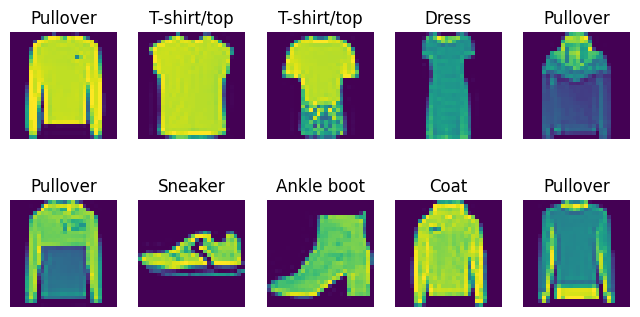

In [12]:
torch.manual_seed(42)

#Convert the dataset into Tensor used by PyTorch
transform=transforms.Compose([
         transforms.ToTensor(),
        ])

#Download the Fashion-MNIST data directly from PyTorch
#The downloaded datasets are stored in data folder under the same folder with this jupyter notebook file
train_dataset = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST('./data', train=False, download=True, transform=transform)

# Create subset indices
train_subset_size = 500
test_subset_size = 50
train_subset_indices = torch.randperm(len(train_dataset))[:train_subset_size]
test_subset_indices = torch.randperm(len(test_dataset))[:test_subset_size]

# Create subset dataset
train_subset = Subset(train_dataset, train_subset_indices)
test_subset = Subset(test_dataset, test_subset_indices)

#Load the datasets into DataLoader
train_dataloader = DataLoader(train_subset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_subset, batch_size=64, shuffle=False)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

#Plot some Fashion-MNIST examples
dataiter = iter(train_dataloader)
samples = next(dataiter)
fig, ax = plt.subplots(2, 5, figsize=(8, 4))
example_images = samples[0][:10]
example_labels = samples[1][:10]
plot_digits(example_images, example_labels, images_per_row=5)
plt.show()

#### Pre-train a convolutional neural network using `Fashion-MNIST` data

In the following questions, you will focus on performing and evaluating hidden trigger backdoor attack; therefore, directly run the following unit to pre-trained a CNN model.

In [13]:
#Pre-define the CNN clsss for image classification
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50) 
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x)) 
        x = F.max_pool2d(x, 2)  
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#Set up some hyperparameters
torch.manual_seed(2)
epochs = 10
learning_rate = 0.01
weight_decay = 5e-4
lossfunction = nn.CrossEntropyLoss()
clean_model = CNN()
clean_optimizer = optim.Adam(clean_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

#Train the clean model
for epoch in range(1, epochs + 1):
    train(epoch, clean_model, train_dataloader, clean_optimizer, lossfunction)

#Test the clean model
test(clean_model, test_dataloader)

epoch (1): Train accuracy: 0.2260, loss: 0.033
epoch (2): Train accuracy: 0.4720, loss: 0.021
epoch (3): Train accuracy: 0.6180, loss: 0.016
epoch (4): Train accuracy: 0.6480, loss: 0.015
epoch (5): Train accuracy: 0.6860, loss: 0.012
epoch (6): Train accuracy: 0.7140, loss: 0.011
epoch (7): Train accuracy: 0.7420, loss: 0.010
epoch (8): Train accuracy: 0.7580, loss: 0.010
epoch (9): Train accuracy: 0.7700, loss: 0.009
epoch (10): Train accuracy: 0.7840, loss: 0.009
Test accuracy: 0.8200, macro f1_score: 0.7815


#### Construct base instances (base label c) and target instances (across all labels that are different from c) for backdoor attacks

-------Base instances-------


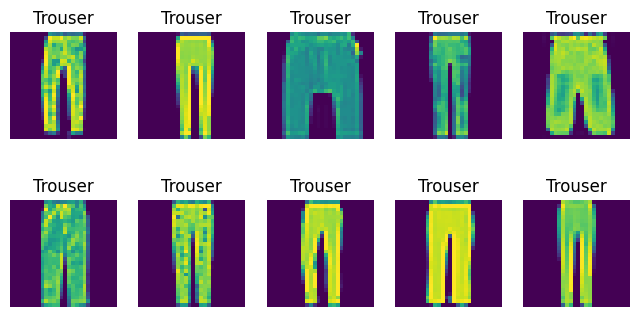

-------Target instances-------


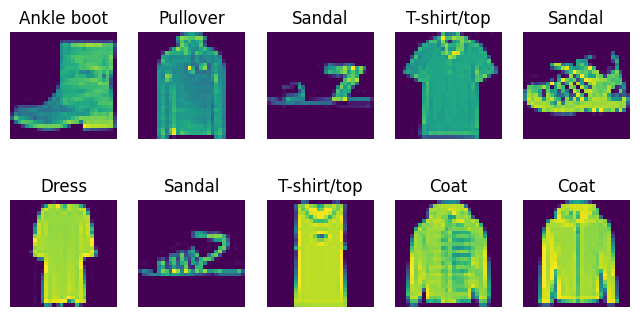

In [14]:
#Choose a base label: all the images with trojan trigger should be classified as this label
base_label_name = 'Trouser'
base_label_index = class_names.index(base_label_name)

#Obtain all the target instances and base instances
target_instances = []  #Instances with target_label (target_label is the label that is different from base_label) 
target_labels = []
base_instances = []    #Instances with base_label 
base_labels = []

for samples, labels in train_subset:
    if labels == base_label_index:
        base_instances.append(samples)
        base_labels.append(labels)
    if labels != base_label_index:
        target_instances.append(samples)
        target_labels.append(labels)

target_instances = torch.stack(target_instances)
base_instances = torch.stack(base_instances)

#Plot some base instances
print("-------Base instances-------")
fig, ax = plt.subplots(2, 5, figsize=(8, 4))
example_images = base_instances[:10]
example_labels = base_labels[:10]
plot_digits(example_images, example_labels, images_per_row=5)
plt.show()

print("-------Target instances-------")
#Plot some target instances
fig, ax = plt.subplots(2, 5, figsize=(8, 4))
example_images = target_instances[:10]
example_labels = target_labels[:10]
plot_digits(example_images, example_labels, images_per_row=5)
plt.show()

#### Question 5 (10 points):  
**Please implement a hidden trigger backdoor attack that first adds trojan trigger patten to the target images, and then perturbs the base images toward the target images with trojan trigger to generate the perturbed images, where these perturbed images are the final poisoned images. Afterwards, injects these poisoned images into the training data `train_subset`, such that the CNN model re-trained on the poisoned data would correctly classify the test images without trojan trigger, but misclassify the test images with trojan trigger as the base label `base_label_name`.**

**First, define `FeatureCollisionNet` to construct a feature collision class to facilitate the optimization of the perturbed images. Then, implement the function `answer_five( )` to add trojan trigger to the target images, and use feature collision to generate the perturbed images. Feature collision can be formalized as an optimization problem $x = min \|f(x) - f(x_t)\|^2_2 + \beta\|x - x_c)\|^2_2$, where $f(\cdot)$ is a neural network used to learn the task-specific features of an input image, $x_t$ is a target image, and $x_c$ is a base image. You can use the clean convoutional neural network `clean_model` pre-trained in the previous unit as the neural network to learn the task-specific features. By minimizing $\|f(x) - f(x_t)\|^2_2 + \beta\|x - x_c)\|^2_2$, the optimal $x$ can be extracted as the perturbed images.**  

**Set `beta=` using `1`, `5`, respectively to evaluate how `beta` impacts on the feature collision from base instance and target instance.** 

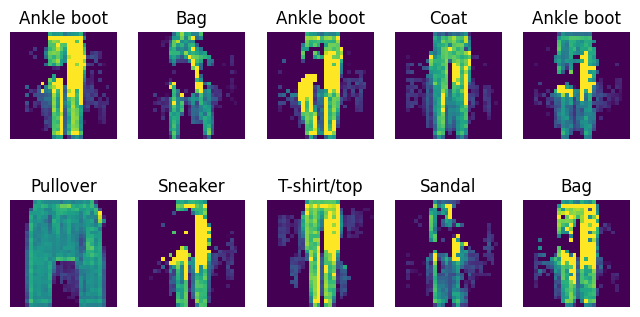

In [16]:
torch.manual_seed(42)
epochs = 50              
learning_rate = 0.1
poisoned_account = 50

trojan_trigger = torch.Tensor([[1.]]).repeat(14, 8)

#Code here: set beta as 1, 5 respectively
beta = 5

#Define the feature collision clsss to obtain the objective function
class FeatureCollisionNet(nn.Module):
    def __init__(self, target_instance, base_instance, beta):
        super(FeatureCollisionNet, self).__init__()
        #Code here: define self.x and initialize it as a base_instance
        self.x = torch.clone(base_instance)
        #Code here: add self.x to the model parameter (requires_grad needs to be True)
        self.x = Parameter(self.x, requires_grad=True)

        self.beta = beta                               
        
        self.pretrained_model = clean_model 
        self.pretrained_model.eval()  
        for param in self.pretrained_model.parameters():
            param.requires_grad = False 

    def get_task_specific_features(self, input_instance):
        output = self.pretrained_model(input_instance)
        return output
    
    def forward(self, target_instance, base_instance):
        x = torch.clamp(self.x, 0, 1)
        
        #Code here: extract the task-soefici features for x
        task_specific_x = self.get_task_specific_features(x)
        #Code here: extract the task-soefici features for target_instance
        task_specific_target = self.get_task_specific_features(target_instance)
        
        #Feature collision is to minimize an objective function: ||f(x) - f(x_t)||^2 + beta||x - x_c)||^2
        #Code here: construct the objective function for feature collision
        objective = torch.norm(task_specific_x - task_specific_target, p=2) ** 2 + self.beta * torch.norm(x - base_instance, p=2) ** 2
        
        return objective
    

def answer_five(beta):       
    triggered_instances = target_instances.clone()
    triggered_instances[:, 0, :14, :8] = trojan_trigger
    
    poisoned_instances = []
    
    for i in range(poisoned_account):
        #Code here: randomly select one triggered instance from triggered_instances
        triggered_instance = triggered_instances[torch.randint(0, triggered_instances.size(0), (1,))]
        #Code here: randomly select one base instance from base_instances
        base_instance = base_instances[torch.randint(0, base_instances.size(0), (1,))]
        
        parameter_to_update = []
        
        #Code here: instantiate a feature collision model from FeatureCollisionNet (need to pass three parameters)
        feature_collision_model = FeatureCollisionNet(triggered_instance, base_instance, beta)
        
        for p in feature_collision_model.parameters():
            if p.requires_grad:
                parameter_to_update.append(p)
                break
        
        #Code here: specify the optimizer used for gradient descent for feature collision model training
        #Note: parameter_to_update is the model parameter tensor that needs to be passed to the optimizer  
        feature_collision_model_optimizer = optim.Adam(parameter_to_update, lr=learning_rate)
        
        for epoch in range(1, epochs + 1):
            #Code here: call train_feature_collision_model() function (need to pass 6 parameters)
            train_feature_collision_model(i, epoch, feature_collision_model, feature_collision_model_optimizer, triggered_instance, base_instance)
        
        poisoned_instances.append(torch.clamp(parameter_to_update[0].squeeze(0), 0, 1))
    
    poisoned_instances = torch.stack(poisoned_instances)
    
    return poisoned_instances.detach()

#Run your function in the cell to return the results
poisoned_instances = answer_five(beta)

#Plot some poisoned instances: the instances should look like the base instance (Trouser) 
#but their task-specific features are closer to the target instances with trigger (tend to be predicted as target labels)
poisoned_predicted = predict_label(clean_model, poisoned_instances)
fig, ax = plt.subplots(2, 5, figsize=(8, 4))
example_images = poisoned_instances[:10]
example_labels = poisoned_predicted[:10]
plot_digits(example_images, example_labels, images_per_row=5)
plt.show()

#### <font color='red'>Answer 5 (double click here to answer the questions in this cell):</font> 
Hidden trigger backdoor attack is to perturb the base images towards the target images with trojan trigger, where the perturbed images look like the base instances but get closer to task-specific features of the target instances with trojan trigger. In this question, the base label is "Trousers". Based on the perturbed images plotted above, please submmarize how `beta` with different values (`1` and `5`) impacts on the looks of the perturbed images and their relationships with base images and target images: ( when using the 'beta' value 1, the images are less perturbed and the images still closely resemble the base image when compared to using a 'beta' value of 5. This is because when using a smaller 'beta' value, the perturbations are less effective compared to a higher value, however, when using a value of '5', the image may still look like the label 'Trousers', however, it would include features that would activate the backdoor attack.)

Based on the perturbed images plotted above, you cannot spot the trojan trigger pattern. Please explain why: ( Based on the perturbed images, we are unable to spot the trojan trigger pattern because of the low 'beta' value that we are using. The perturbation is able to remain within the perceptual limits because the beta value is such a small value. Also, the attack we are using perturbs the base image 'Trousers' toward specific features of the target image with the trigger without addinng a visible trigger pattern that we would be able to see within the pixel space.)

#### Question 6 (10 points): 

**Implement the function `answer_six( )` to add the poisoned images to the training data and retrain the CNN model to evaluate the hidden trigger backdoor attack performance, including the accuracy on the test images without trojan trigger and the accuracy on the test images with trojan trigger.**

In [18]:
torch.manual_seed(42)
epochs = 10
learning_rate = 0.01
weight_decay = 5e-4
lossfunction = nn.CrossEntropyLoss()

def answer_six():
    poisoned_labels = torch.full((poisoned_account,), base_label_index, dtype=torch.long)
    
    #Code here: construct poisoned training dataset using (poisoned_instances, poisoned_labels)
    poisoned_dataset = TensorDataset(poisoned_instances, poisoned_labels)
    
    train_subset_wrapped = WrappedDataset(train_subset)
    
    #Code here: concatenate train_subset_wrapped and poisoned_dataset to poisoned_train_dataset 
    poisoned_train_dataset =  ConcatDataset([train_subset_wrapped, poisoned_dataset])
    #Code here: load poisoned_train_dataset into DataLoader
    poisoned_train_dataloader = DataLoader(poisoned_train_dataset, batch_size=64, shuffle=True)
    
    #Code here: instantialize a backdoor model from the defined CNN class
    backdoor_model = CNN()  
    #Code here: specify the optimizer used for gradient descent for backdoor model training
    backdoor_optimizer = optim.Adam(backdoor_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    print("-------Training a backdoor model using the poisoned images-------")
    for epoch in range(1, epochs + 1):
        #Code here: call train() function (need to pass five parameters)
        #Note: the model, optimizer, and dataloader should be backdoor model/optimizer and poisoned_train_dataloader
        train(epoch, backdoor_model, poisoned_train_dataloader, backdoor_optimizer, lossfunction)
    
    print("-------Test the backdoor_model on the clean test data-------")
    #Code here: call test() function (need to pass two parameters)
    #Note: the model should be backdoor model, and the clean test data should be test_dataloader
    test(backdoor_model, test_dataloader)
    
    print("-------Test the backdoor_model on the poisoned test data with trojan trigger-------")
    test_instances = []
    test_labels = []
    
    for samples, labels in test_subset:
        if labels != base_label_index:
            backdoor_test_instances = samples.clone()
            backdoor_test_instances[0, :14, :8] = trojan_trigger
            test_instances.append(backdoor_test_instances)
            test_labels.append(labels)
    
    test_instances = torch.stack(test_instances)
    test_labels = torch.tensor(test_labels)

    #Code here: construct backdoor test dataset using (test_instances, test_labels)
    backdoor_test_dataset = TensorDataset(test_instances, test_labels)
    #Code here: load backdoor_test_dataset into DataLoader
    backdoor_test_dataloader = DataLoader(backdoor_test_dataset, batch_size=64, shuffle=False)
    
    #Code here: call test() function (need to pass two parameters)
    #Note: the model should be backdoor model, and the test data should be backdoor_test_dataloader
    test(backdoor_model, backdoor_test_dataloader)

#Run your function in the cell to return the results
answer_six()

-------Training a backdoor model using the poisoned images-------
epoch (1): Train accuracy: 0.2182, loss: 0.035
epoch (2): Train accuracy: 0.5509, loss: 0.021
epoch (3): Train accuracy: 0.6418, loss: 0.015
epoch (4): Train accuracy: 0.6873, loss: 0.014
epoch (5): Train accuracy: 0.7182, loss: 0.012
epoch (6): Train accuracy: 0.7509, loss: 0.010
epoch (7): Train accuracy: 0.7764, loss: 0.009
epoch (8): Train accuracy: 0.7909, loss: 0.008
epoch (9): Train accuracy: 0.8255, loss: 0.008
epoch (10): Train accuracy: 0.8418, loss: 0.007
-------Test the backdoor_model on the clean test data-------
Test accuracy: 0.7400, macro f1_score: 0.6887
-------Test the backdoor_model on the poisoned test data with trojan trigger-------
Test accuracy: 0.4000, macro f1_score: 0.1836


#### <font color='red'>Answer 6 (double click here to answer the questions in this cell):</font> 
When testing the backdoor model on the test data without trojan trigger, the test accuracy is: ( 0.7400 ); f1 score is: ( 0.6887 ) <br>
When testing the backdoor model on the test data with trojan trigger, the test accuracy is: ( 0.4000 ); f1 score is: ( 0.1836 ) <br>
Based on these test performances, please describe your observation on hidden trigger backdoor attack: ( Based on the test performances, the hidden trigger backdoor attack has a lower performance when a trojan trigger is used compared to when the backdoor attack does not have a trojan trigger. This shows that when the inputs are not poisoned by the trojan trigger, the model is still able to predict the correct labels. ) <br>
And also summarize the advantage and disadvantage of hidden trigger backdoor attack regarding the visibility of its generated poisoned instances and the attack performance: ( The advantage and disadvantage of the hidden trigger backdoor attack when taking into account the visibility of the generated poisoned instances is that there is higher stealth and effective misclassifications due to the 'beta' value that is able to be used, causing the success rate to remain high. The disadvantage is that that attack is sensitive to model and training dynamics and requires calibration of the 'beta' value to get the attack to work. If the 'beta' value is too low, the perturbation may not be strong enough to allow for the backdoor attack to be activated and/or if the value is too high, the image can become distorted and the trigger can become visible, causing the stealth of the attack to be lowered.)